# TP 2 : RL

Le but de ce TP sera de découvrir et mettre en place un algorithme d'apprentissage par renforcement profond : le DQN.
Vous apprendrez à un agent à jouer au jeu du cartpole, qui consiste à déplacer une plateforme sur laquelle est posé un baton de manière à ce que le baton reste en équilibre sur la plateforme.

Nous allons utiliser la librairie TensorFlow et faire tourner notre code sous Google Colab pour nos TP, ce qui aura l'avantage de nous permettre d'utiliser les GPUs mis à disposition gratuitement par Google.
Vous êtes libre d'utiliser une autre librairie que TensorFlow si vous en maîtrisez une autre ou votre machine personnelle si celle-ci possède un GPU suffisant, mais il est probable que les phases d'entraînement soit plus rapides sous Colab.

N'hésitez pas à vous référer aux docs de TensorFlow 2 et Keras disponibles sur internet lors de ce TP.

Ce TP peut s'effectue individuellement.
Veuillez respecter les consignes suivantes pour le rendu de votre travail :

*   Renommez le selon le format suivant : "TP_RL_prenom_nom.ipynb".
*   Veillez à ce que votre nom et prénom soient complétés dans la cellule ci-dessous.
*   Veillez à avoir bien exécuté toutes les cellules de code et que les résultats soient tous bien visible dans le notebook sans nécessiter une ré-exécution.
*   Partagez le notebook avec ranvier.thomas.pro@gmail.com.

Si vous avez effectué le TP autrement que sur Google Colab :

*   Renommez le selon le format suivant : "TP_RL_prenom_nom.ipynb".
*   Téléchargez le fichier ipynb.
*   Envoyez le fichier en pièce-jointe à ranvier.thomas.pro@gmail.com, en indiquant en tant qu'objet : "TP RL prenom nom".

---

## Veuillez compléter vos noms et prénoms ci-dessous :

*   **Prenom** : Florent
*   **Nom** : HAFFNER

In [ ]:
#@title Installation des dépendances

%%capture
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!pip install colabgymrender==1.0.2

In [ ]:
%%capture
import tensorflow as tf
import gym
import numpy as np
from colabgymrender.recorder import Recorder
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

---
# Visualisation d'un épisode de Cartpole

Vous allez utiliser l'environement cartpole proposé par la librairie gym. A chaque étape l'environement nous envoie une observation correspondant à l'état actuel de l'environement et on doit envoyer une action (0 ou 1 pour gauche ou droite) en réponse.

Commencez par visualiser un épisode en ne sélectionnant que des actions aléatoires.

In [ ]:
# Environment initialization
env = gym.make('CartPole-v1')
# Put the environment in a wrapper to save the episode video
env = Recorder(env, './example')

# Start a new episode and get the first environment state
state = env.reset()
done = False
# While the episode is not over
while not done:
    # Select a random action
    action_index = random.randrange(env.action_space.n)
    # Execute selected action in the environment and get new observation and reward
    next_state, reward, done, _ = env.step(action_index)

# Play the episode video
env.play()

100%|██████████| 31/31 [00:00<00:00, 224.00it/s]


---
# Déclaration des hyperparamètres

Le but de ce TP n'étant pas de chercher les meilleurs hyperparamètres possibles vous trouverez ci-dessous l'initilisation d'hyperparamètres par défaut qui donnent de bons résultats.

In [ ]:
# Reinitialize environment
env = gym.make('CartPole-v1')

# Get environment observation size and number of possible actions
obs_size = env.observation_space.shape[0]
nb_actions = env.action_space.n

#Hyper Parameters
training_episodes = 200                     # Max number of training episodes
gamma = .95                                 # Discount factor used in Q-function
learning_rate = .001                        # Learning rate of the optimizer
batch_size = 24
epsilon_max = 1.                            # Maximum epsilon value at 1.
epsilon_min = .05                           # Minimum epsilon value at .05
epsilon_decay = .995                        # Epsilon decay factor at .995
replay_memory_capacity = 2500               # Limit memory capacity at 2500
print_step = 10                             # Print recap every 10 steps
target_avg_reward = 200                     # Early stop if avg reward >= 200

---
# Création de la replay memory

La replay memory est utilisée pour stocker les transitions entre l'agent et l'environement. Chaque transition stockée est composée de l'état de départ, l'action réalisée par l'agent, l'état d'arrivée, le reward obtenu et si l'état d'arrivée est terminal ou non.

In [ ]:
# class ReplayMemory:
#     def __init__(self, capacity):
#         self._capacity = capacity
#         ...

#     def push(self, state, next_state, action, reward, done):
#         """
#         Cette méthode doit permettre de stocker une transition dans la mémoire
#         tout en s'assurant que le nombre d'transitions stockée ne dépasse pas
#         sa capacité.
#         Si c'est le cas la nouvelle transition doit écraser la plus ancienne.

#         Une transition contient :
#             - state: np.array, l'état de départ
#             - next_state: np.array, l'état d'arrivée
#             - action: tf.tensor, l'action effectuée. Dans un soucis d'efficience
#                       vous devez stocker l'action directement sous forme de
#                       one-hot tensor, obtenu avec : action = tf.one_hot(action_index, nb_actions)
#             - reward: int, le reward obtenu grâce à l'action effectuée
#             - done: boolean, indique si le baton est tombé ou non
#         """
#         ...

#     def sample(self, batch_size):
#         """
#         Cette méthode doit extraire une minibatch de la taille voulue de la
#         mémoire de manière aléatoire. Elle prend en entrée la taille de la batch
#         à extraire.

#         La méthode doit retourner :
#             - state_s: np.array, contenant les états de départ
#             - state_next_s: np.array, contenant les états d'arrivées
#             - action_s: tf.tensor, contenant les one-hots vectors des actions
#             - rewards_s: tf.tensor, contenant rewards
#             - opp_done_s: tf.tensor, contenant l'opposé du flag 'done' converti en float
#         """
#         ...
#         return state_s, state_next_s, action_s, rewards_s, opp_done_s

#     def __len__(self):
#         """
#         Cette méthode override les appels de length sur l'objet ReplayMemory.
#         Elle doit retourner la quantité actuelle de transitions sauvegardées
#         dans la mémoire.
#         """
#         ...

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self._capacity = capacity
        self._state_h = []
        self._next_state_h = []
        self._action_h = []
        self._reward_h = []
        self._done_h = []

    def push(self, state, next_state, action, reward, done):
        """
        Cette méthode doit permettre de stocker une transition dans la mémoire
        tout en s'assurant que le nombre d'transitions stockée ne dépasse pas
        sa capacité.
        Si c'est le cas la nouvelle transition doit écraser la plus ancienne.

        Une transition contient :
            - state: np.array, l'état de départ
            - next_state: np.array, l'état d'arrivée
            - action: tf.tensor, l'action effectuée. Dans un soucis d'efficience
                      vous devez stocker l'action directement sous forme de
                      one-hot tensor, obtenu avec : action = tf.one_hot(action_index, nb_actions)
            - reward: int, le reward obtenu grâce à l'action effectuée
            - done: boolean, indique si le baton est tombé ou non
        """
        self._state_h.append(state)
        self._next_state_h.append(next_state)
        self._action_h.append(action)
        self._reward_h.append(reward)
        self._done_h.append(done)
        
        if len(self._state_h) >= self._capacity:
            del self._state_h[0]
            del self._next_state_h[0]
            del self._action_h[0]
            del self._reward_h[0]
            del self._done_h[0]

    def sample(self, batch_size):
        """
        Cette méthode doit extraire une minibatch de la taille voulue de la
        mémoire de manière aléatoire. Elle prend en entrée la taille de la batch
        à extraire.

        La méthode doit retourner :
            - state_s: np.array, contenant les états de départ
            - state_next_s: np.array, contenant les états d'arrivées
            - action_s: tf.tensor, contenant les one-hots vectors des actions
            - rewards_s: tf.tensor, contenant rewards
            - opp_done_s: tf.tensor, contenant l'opposé du flag 'done' converti en float
        """
        index_list = np.random.choice(range(len(self._state_h)), size=batch_size)
        
        state_s: np.array = np.array([self._state_h[i] for i in index_list])
        state_next_s: np.array = np.array([self._next_state_h[i] for i in index_list])
        action_s: tf.tensor = tf.convert_to_tensor([self._action_h[i] for i in index_list])
        rewards_s: tf.tensor = tf.convert_to_tensor([self._reward_h[i] for i in index_list])
        opp_done_s: tf.tensor = tf.convert_to_tensor([1-float(self._done_h[i]) for i in index_list])

        return state_s, state_next_s, action_s, rewards_s, opp_done_s

    def __len__(self):
        """
        Cette méthode override les appels de length sur l'objet ReplayMemory.
        Elle doit retourner la quantité actuelle de transitions sauvegardées
        dans la mémoire.
        """
        return len(self._state_h)

---
# Création de l'agent

L'agent apprend à intéragir et executer ses actions avec l'environnement.

In [ ]:
# class Agent():
#     def __init__(self, replay_memory, model, optimizer, loss_function, env):
#         self._rm = replay_memory
#         self._epsilon = epsilon_max
#         self._model = model
#         self._optimizer = optimizer
#         self._loss_function = loss_function
#         self._env = env
#         # History
#         self._reward_hist = []

#     def train(self):
#         """
#         Méthode principale, lance l'entraînement de l'agent.
#         """
#         start = time.time()
#         avg_reward = 0
#         for episode in range(training_episodes):
#             # Run 1 episode
#             episode_reward = self._run_episode()
#             self._reward_hist.append(episode_reward)
#             avg_reward += episode_reward
#             if (episode + 1) % print_step == 0:
#                 print(f'episode: {episode + 1}/{training_episodes}, avg reward: {avg_reward / print_step}, e: {self._epsilon}')
#                 # Early stop
#                 if avg_reward / print_step >= target_avg_reward:
#                     break
#                 avg_reward = 0
#         print(f'training done in {time.time() - start:.2f}s')
#         self._plot_history()

#     def _run_episode(self):
#         """
#         Cette méthode doit executer un épisode d'apprentissage.
#         """
#         # Initialize environment and get first state
#         # convert the state to np.array type
#         ...

#         episode_reward = 0
#         done = False
#         while not done:
#             # Select an action, randomly in epsilon % of the time, and using
#             # the model output otherwise.
#             # Obtain the model output: self._model(np.expand_dims(state, axis=0))
#             # You need to convert the model output which is a score for each
#             # possible action to the index of the action for which the model
#             # predicts the highest score.
#             ...

#             # Perform selected action in the environment, get next state, reward
#             # and done status
#             ...

#             # Convert the next state to np.array type
#             ...

#             episode_reward += reward
#             # Convert the selected action index to a one-hot tensor for
#             # efficiency (cf. tf.one_hot())
#             ...

#             # Add observation to the replay memory
#             ...

#             # Add observation to the replay memory (cf. self._rm.push)
#             ...
            
#             # Replace current state with next state
#             ...

#             # If there are enough transitions in the replay memory extract a
#             # minibatch from the memory and call the optimize function to train
#             # the model on the minibatch
#             if len(self._rm) > batch_size:
#                 # Extract a minibatch from the replay memory (cf. self._rm.sample)
#                 ...

#                 # Call optimize on the extracted minibatch to train the model
#                 ...
                
#                 # Update epsilon
#                 self._epsilon = max(epsilon_min, self._epsilon * epsilon_decay)
#         return episode_reward

#     @tf.function
#     def _optimize(self, state_s, state_next_s, action_s, rewards_s, opp_done_s):
#         """
#         Cette méthode calcule la Q-loss, elle doit ensuite faire la
#         backpropagation.
#         """
#         q_values_target = self._model(state_next_s)
#         q_values_target = rewards_s + (gamma * tf.reduce_max(q_values_target, axis=1)) * opp_done_s
#         with tf.GradientTape() as tape:
#             q_values_pred = self._model(state_s)
#             q_values_pred = tf.reduce_sum(tf.multiply(q_values_pred, action_s), axis=1)
#             loss = self._loss_function(q_values_target, q_values_pred)
#         # Backpropagation (compute gradients and apply gradients using tf functions)
#         ...

#     def _plot_history(self):
#         plt.figure(figsize=(10, 5))
#         plt.plot(self._reward_hist)
#         plt.xlabel('episodes')
#         plt.ylabel('reward')
#         plt.title('Reward per episode')
#         plt.show()
    
#     def real_episode(self, env):
#         state = env.reset()
#         done = False
#         while not done:
#             output = self._model(np.expand_dims(state, axis=0))
#             action_index = np.argmax(output.numpy())
#             state, _, done, _ = env.step(action_index)

In [ ]:
class Agent():
    def __init__(self, replay_memory, model, optimizer, loss_function, env):
        self._rm = replay_memory
        self._epsilon = epsilon_max
        self._model = model
        self._optimizer = optimizer
        self._loss_function = loss_function
        self._env = env
        # History
        self._reward_hist = []

    def train(self):
        """
        Méthode principale, lance l'entraînement de l'agent.
        """
        start = time.time()
        avg_reward = 0
        for episode in range(training_episodes):
            # Run 1 episode
            episode_reward = self._run_episode()
            self._reward_hist.append(episode_reward)
            avg_reward += episode_reward
            if (episode + 1) % print_step == 0:
                print(f'episode: {episode + 1}/{training_episodes}, avg reward: {avg_reward / print_step}, e: {self._epsilon}')
                # Early stop
                if avg_reward / print_step >= target_avg_reward:
                    break
                avg_reward = 0
        print(f'training done in {time.time() - start:.2f}s')
        self._plot_history()

    def _run_episode(self):
        """
        Cette méthode doit executer un épisode d'apprentissage.
        """
        # Initialize environment and get first state
        # convert the state to np.array type
        state = self._env.reset()
        episode_reward = 0
        done = False
        while not done:
            env = self._env

            # Select an action, randomly in epsilon % of the time, and using
            # the model output otherwise.
            # Obtain the model output: self._model(np.expand_dims(state, axis=0))
            # You need to convert the model output which is a score for each
            # possible action to the index of the action for which the model
            # predicts the highest score.
            
            min_range = 0
            max_range = 1
            generate_action_percentage = min_range + (max_range-min_range)*random.random()

            if generate_action_percentage > self._epsilon:
              output_model = self._model(np.expand_dims(state, axis=0))
              action_index = np.argmax(output_model)
            else:
              # Select a random action
              action_index = random.randrange(nb_actions)
              
            # Execute selected action in the environment and get new observation and reward

            # Perform selected action in the environment, get next state, reward
            # and done status
            next_state, reward, done, _ = env.step(action_index)
            episode_reward += reward

            # Convert the selected action index to a one-hot tensor for efficiency (cf. tf.one_hot())
            selected_action_one_hot = tf.one_hot(action_index, nb_actions)

            # Add observation to the replay memory (cf. self._rm.push)
            self._rm.push(state, next_state, selected_action_one_hot, reward, done)
            
            # Replace current state with next state
            state = next_state

            # If there are enough transitions in the replay memory extract a
            # minibatch from the memory and call the optimize function to train
            # the model on the minibatch
            if len(self._rm) > batch_size:
                # Extract a minibatch from the replay memory (cf. self._rm.sample)
                batch_state_s, batch_state_next_s, batch_action_s, batch_rewards_s, batch_opp_done_s = self._rm.sample(batch_size)

                # Call optimize on the extracted minibatch to train the model
                self._optimize(
                    batch_state_s,
                    batch_state_next_s,
                    batch_action_s,
                    batch_rewards_s,
                    batch_opp_done_s
                )
                
                # Update epsilon
                self._epsilon = max(epsilon_min, self._epsilon * epsilon_decay)
        return episode_reward

    @tf.function
    def _optimize(self, state_s, state_next_s, action_s, rewards_s, opp_done_s):
        """
        Cette méthode calcule la Q-loss, elle doit ensuite faire la
        backpropagation.
        """
        q_values_target = self._model(state_next_s)
        q_values_target = rewards_s + (gamma * tf.reduce_max(q_values_target, axis=1)) * opp_done_s
        with tf.GradientTape() as tape:
            q_values_pred = self._model(state_s)
            q_values_pred = tf.reduce_sum(tf.multiply(q_values_pred, action_s), axis=1)
            loss = self._loss_function(q_values_target, q_values_pred)
        
        # Backpropagation (compute gradients and apply gradients using tf functions)
        gradients = tape.gradient(loss, self._model.trainable_variables)
        # Mise à jour des paramètres en utilisant l’algorithme d’optimisation
        # (backward propagation)
        self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))

    def _plot_history(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self._reward_hist)
        plt.xlabel('episodes')
        plt.ylabel('reward')
        plt.title('Reward per episode')
        plt.show()
    
    def real_episode(self, env):
        state = env.reset()
        done = False
        while not done:
            output = self._model(np.expand_dims(state, axis=0))
            action_index = np.argmax(output.numpy())
            state, _, done, _ = env.step(action_index)

---
# Entraînement de l'agent

Si tout est correct vous devriez voir la récompense moyenne des 10 derniers épisodes d'apprentissage commencer à augmenter entre 50 et 100 épisodes.

episode: 10/200, avg reward: 20.4, e: 0.40565285250151817
episode: 20/200, avg reward: 12.0, e: 0.22229219984074702
episode: 30/200, avg reward: 11.1, e: 0.12743425563174798
episode: 40/200, avg reward: 10.9, e: 0.07379076075438468
episode: 50/200, avg reward: 9.7, e: 0.05
episode: 60/200, avg reward: 11.3, e: 0.05
episode: 70/200, avg reward: 12.9, e: 0.05
episode: 80/200, avg reward: 16.7, e: 0.05
episode: 90/200, avg reward: 33.0, e: 0.05
episode: 100/200, avg reward: 15.5, e: 0.05
episode: 110/200, avg reward: 26.4, e: 0.05
episode: 120/200, avg reward: 24.2, e: 0.05
episode: 130/200, avg reward: 31.4, e: 0.05
episode: 140/200, avg reward: 39.2, e: 0.05
episode: 150/200, avg reward: 31.8, e: 0.05
episode: 160/200, avg reward: 47.9, e: 0.05
episode: 170/200, avg reward: 53.6, e: 0.05
episode: 180/200, avg reward: 70.9, e: 0.05
episode: 190/200, avg reward: 99.8, e: 0.05
episode: 200/200, avg reward: 257.0, e: 0.05
training done in 59.75s


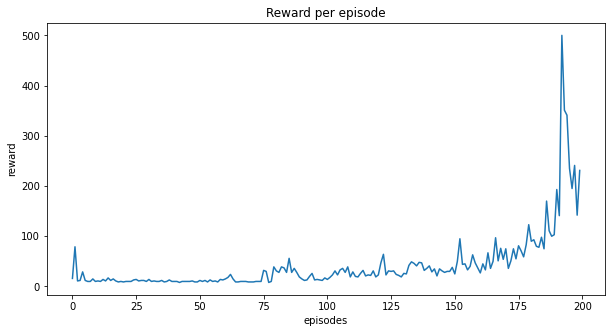

In [ ]:
# Define a fully-connected model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(units=32, input_dim=obs_size, activation='relu'),
  tf.keras.layers.Dense(units=nb_actions)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.MeanSquaredError()
replay_memory = ReplayMemory(replay_memory_capacity)

# Create the agent
agent = Agent(replay_memory, model, optimizer, loss_function, env)
agent.train()

episode: 10/200, avg reward: 21.8, e: 0.37816180712868996
episode: 20/200, avg reward: 11.5, e: 0.21248679717794605
episode: 30/200, avg reward: 11.0, e: 0.12242520289863423
episode: 40/200, avg reward: 17.4, e: 0.051178420962124486
episode: 50/200, avg reward: 23.9, e: 0.05
episode: 60/200, avg reward: 36.1, e: 0.05
episode: 70/200, avg reward: 34.9, e: 0.05
episode: 80/200, avg reward: 74.6, e: 0.05
episode: 90/200, avg reward: 96.9, e: 0.05
episode: 100/200, avg reward: 140.1, e: 0.05
episode: 110/200, avg reward: 98.2, e: 0.05
episode: 120/200, avg reward: 130.4, e: 0.05
episode: 130/200, avg reward: 290.1, e: 0.05
training done in 62.84s


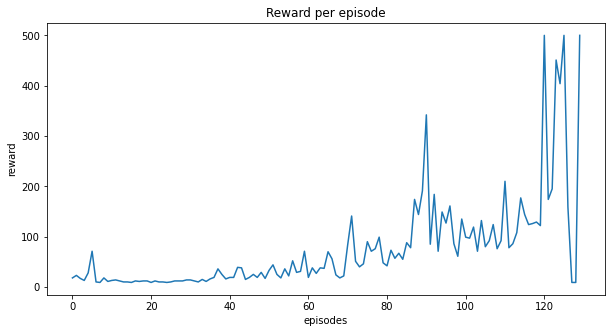

In [ ]:
# Define a fully-connected model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(units=32, input_dim=obs_size, activation='relu'),
  tf.keras.layers.Dense(units=24, activation='relu'),
  tf.keras.layers.Dense(units=nb_actions)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.MeanSquaredError()
replay_memory = ReplayMemory(replay_memory_capacity)

# Create the agent
agent = Agent(replay_memory, model, optimizer, loss_function, env)
agent.train()

In [ ]:
# Visualize test episode
env = gym.make('CartPole-v1')
env = Recorder(env, './episode')
agent.real_episode(env)
env.play()

100%|█████████▉| 501/502 [00:01<00:00, 283.23it/s]
